# XAI Project for signature classification using CEDAR dataset

## Configurations Colab & Kaggle API

In [1]:
!git clone https://github.com/silvano315/eXplainability-for-signature-detection.git

Cloning into 'eXplainability-for-signature-detection'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 176 (delta 94), reused 117 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (176/176), 282.11 KiB | 7.23 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [2]:
import os

os.chdir("eXplainability-for-signature-detection")
os.getcwd()

'/content/eXplainability-for-signature-detection'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Move your Kaggle API to /root/.config/kaggle and /root/.kaggle/kaggle.json

os.makedirs('/root/.kaggle', exist_ok = True)

!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.config/kaggle.json
!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.kaggle/kaggle.json

## Import libraries

In [5]:
import json
import logging
import yaml
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from src.utils.kaggle_downloader import setup_dataset
from src.utils.logger_setup import get_logger
from src.utils.dataset_analyzer import create_dataset_metadata, validate_dataset_consistency, \
                                        save_metadata, load_metadata
from src.utils.eda import print_dataset_statistics, plot_dataset_distribution, \
                            show_sample_images, analyze_image_properties, generate_eda_report
from src.data.cedar_dataset import CEDARDataset, create_dataloaders, create_balanced_splits
from src.model.model_factory import get_available_models, validate_model_config, create_model
from src.training.experiment import Experiment
from src.training.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from src.training.trainer import ModelTrainer
from src.visualization.plot_results import scatter_plot_metrics, plot_confusion_matrix, plot_misclassified_images

## Configurations

In [6]:
# Load config

with open('config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [7]:
# Setup paths

DATA_PATH = Path(config['paths']['data']['raw_path'])
MODELS_PATH = Path(config['paths']['data']['models_path'])
MODELS_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
# Training parameters

BATCH_SIZE = config['training']['batch_size']
NUM_EPOCHS = config['training']['num_epochs']
LEARNING_RATE = config['training']['learning_rate']
NUM_CLASSES = config['dataset']['num_classes']

## Load data

In [9]:
# Download Malimg dataset from Kaggle

dataset_path = setup_dataset()
print(f"Dataset found at: {dataset_path}")

2025-08-04 14:19:54,584 - KaggleDataDownloader - INFO - Downloading dataset: shreelakshmigp/cedardataset
INFO:KaggleDataDownloader:Downloading dataset: shreelakshmigp/cedardataset


Dataset URL: https://www.kaggle.com/datasets/shreelakshmigp/cedardataset


2025-08-04 14:19:58,090 - KaggleDataDownloader - INFO - Dataset downloaded successfully to data/raw/cedardataset
INFO:KaggleDataDownloader:Dataset downloaded successfully to data/raw/cedardataset
2025-08-04 14:19:58,093 - KaggleDataDownloader - INFO - Starting dataset validation...
INFO:KaggleDataDownloader:Starting dataset validation...
2025-08-04 14:19:58,098 - KaggleDataDownloader - INFO - Readme content:
There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers). 
INFO:KaggleDataDownloader:Readme content:
There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers). 
2025-08-04 14:19:58,100 - KaggleDataDownloader - INFO - Dataset validation successful
INFO:KaggleDataDownloader:Dataset validation successful
2025-08-04 14:19

Dataset found at: data/raw/cedardataset


In [10]:
# Generate metadata for the dataset

signatures_path = Path("data/raw/cedardataset/signatures")
metadata = create_dataset_metadata(signatures_path)

2025-08-04 14:19:58,111 - training - INFO - Creating metadata for dataset at data/raw/cedardataset/signatures
2025-08-04 14:19:58,111 - training - INFO - Creating metadata for dataset at data/raw/cedardataset/signatures
2025-08-04 14:19:58,111 - training - INFO - Creating metadata for dataset at data/raw/cedardataset/signatures
INFO:training:Creating metadata for dataset at data/raw/cedardataset/signatures
2025-08-04 14:19:58,119 - training - INFO - Found 1320 images in data/raw/cedardataset/signatures/full_org
2025-08-04 14:19:58,119 - training - INFO - Found 1320 images in data/raw/cedardataset/signatures/full_org
2025-08-04 14:19:58,119 - training - INFO - Found 1320 images in data/raw/cedardataset/signatures/full_org
INFO:training:Found 1320 images in data/raw/cedardataset/signatures/full_org
2025-08-04 14:19:58,130 - training - INFO - Found 1320 images in data/raw/cedardataset/signatures/full_forg
2025-08-04 14:19:58,130 - training - INFO - Found 1320 images in data/raw/cedardatas

In [11]:
# Save or load metadata with FLAG

SAVE_METADATA = False
dataset_metadata_path = Path("metadata/metadata.json")

if SAVE_METADATA:
    save_metadata(metadata, dataset_metadata_path)
else:
    metadata = load_metadata(dataset_metadata_path)

2025-08-04 14:19:58,151 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-08-04 14:19:58,151 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-08-04 14:19:58,151 - training - INFO - Metadata loaded from: metadata/metadata.json
INFO:training:Metadata loaded from: metadata/metadata.json


In [12]:
# Validate dataset consistency (statistics, class distribution, etc.)

validate_metadata = validate_dataset_consistency(metadata)
for key, value in validate_metadata.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
      print(f"{key}: {value}")

2025-08-04 14:19:58,161 - training - INFO - Validating dataset consistency...
2025-08-04 14:19:58,161 - training - INFO - Validating dataset consistency...
2025-08-04 14:19:58,161 - training - INFO - Validating dataset consistency...
INFO:training:Validating dataset consistency...
2025-08-04 14:19:58,167 - training - INFO - Dataset validation complete:
2025-08-04 14:19:58,167 - training - INFO - Dataset validation complete:
2025-08-04 14:19:58,167 - training - INFO - Dataset validation complete:
INFO:training:Dataset validation complete:
2025-08-04 14:19:58,170 - training - INFO -   Total images: 2640
2025-08-04 14:19:58,170 - training - INFO -   Total images: 2640
2025-08-04 14:19:58,170 - training - INFO -   Total images: 2640
INFO:training:  Total images: 2640
2025-08-04 14:19:58,174 - training - INFO -   Type distribution: {'original': 1320, 'forgeries': 1320}
2025-08-04 14:19:58,174 - training - INFO -   Type distribution: {'original': 1320, 'forgeries': 1320}
2025-08-04 14:19:58,

total_images: 2640
type_distribution:
  original: 1320
  forgeries: 1320
subjects_per_type:
  original: 55
  forgeries: 55
total_unique_subjects: 55
samples_per_subject_stats:
  original: {'min': 24, 'max': 24, 'mean': 24.0, 'total_subjects': 55}
  forgeries: {'min': 24, 'max': 24, 'mean': 24.0, 'total_subjects': 55}
consistency_checks:
  all_types_valid: False
  subjects_match_across_types: False
  no_missing_samples: True
missing_samples: []


## Exploratory Data Analysis

2025-08-04 14:20:29,669 - training - INFO - Generating complete EDA report...
2025-08-04 14:20:29,669 - training - INFO - Generating complete EDA report...
2025-08-04 14:20:29,669 - training - INFO - Generating complete EDA report...
INFO:training:Generating complete EDA report...
2025-08-04 14:20:29,673 - training - INFO - Generating dataset statistics...
2025-08-04 14:20:29,673 - training - INFO - Generating dataset statistics...
2025-08-04 14:20:29,673 - training - INFO - Generating dataset statistics...
INFO:training:Generating dataset statistics...
2025-08-04 14:20:29,679 - training - INFO - Creating distribution plots...
2025-08-04 14:20:29,679 - training - INFO - Creating distribution plots...
2025-08-04 14:20:29,679 - training - INFO - Creating distribution plots...
INFO:training:Creating distribution plots...


CEDAR DATASET STATISTICS
Total Images: 2640
Original Signatures: 1320
Forged Signatures: 1320
Balance Ratio: 1.00

SUBJECT ANALYSIS
------------------------------
Original signatures:
  Unique subjects: 55
  Subject range: 1 - 55
  Samples per subject: 24 - 24 (avg: 24.0)

Forgeries signatures:
  Unique subjects: 55
  Subject range: 1 - 55
  Samples per subject: 24 - 24 (avg: 24.0)



2025-08-04 14:20:31,066 - training - INFO - Distribution plots saved to reports/eda
2025-08-04 14:20:31,066 - training - INFO - Distribution plots saved to reports/eda
2025-08-04 14:20:31,066 - training - INFO - Distribution plots saved to reports/eda
INFO:training:Distribution plots saved to reports/eda


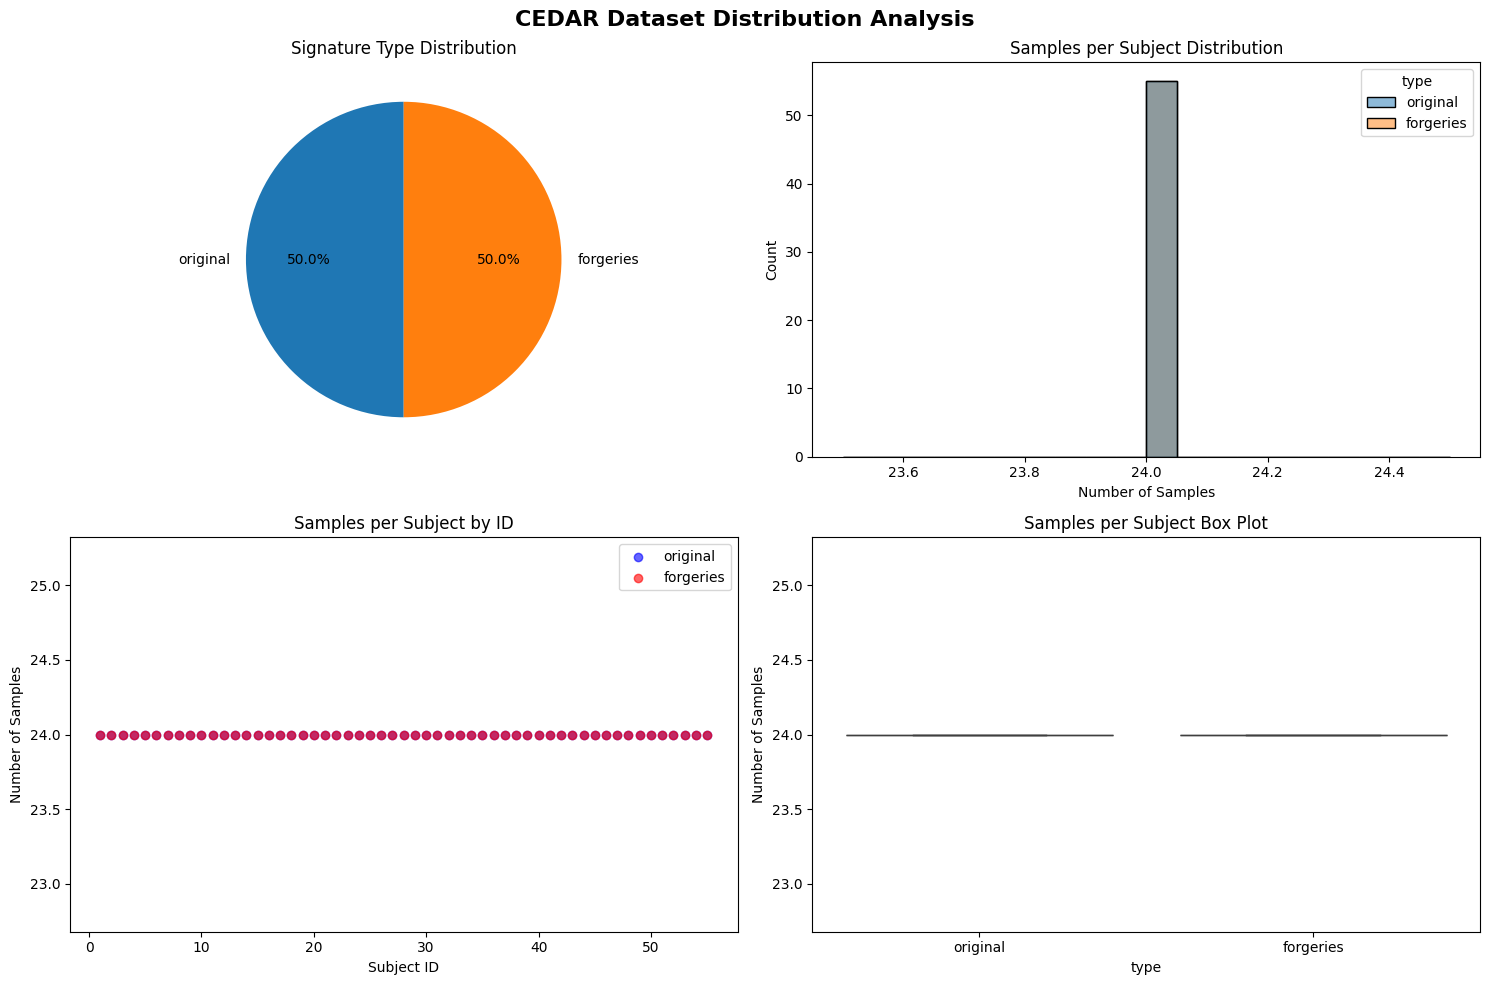

2025-08-04 14:20:31,383 - training - INFO - Showing sample images: 3 subjects, 2 samples each
2025-08-04 14:20:31,383 - training - INFO - Showing sample images: 3 subjects, 2 samples each
2025-08-04 14:20:31,383 - training - INFO - Showing sample images: 3 subjects, 2 samples each
INFO:training:Showing sample images: 3 subjects, 2 samples each
2025-08-04 14:20:35,624 - training - INFO - Sample images saved to reports/eda
2025-08-04 14:20:35,624 - training - INFO - Sample images saved to reports/eda
2025-08-04 14:20:35,624 - training - INFO - Sample images saved to reports/eda
INFO:training:Sample images saved to reports/eda


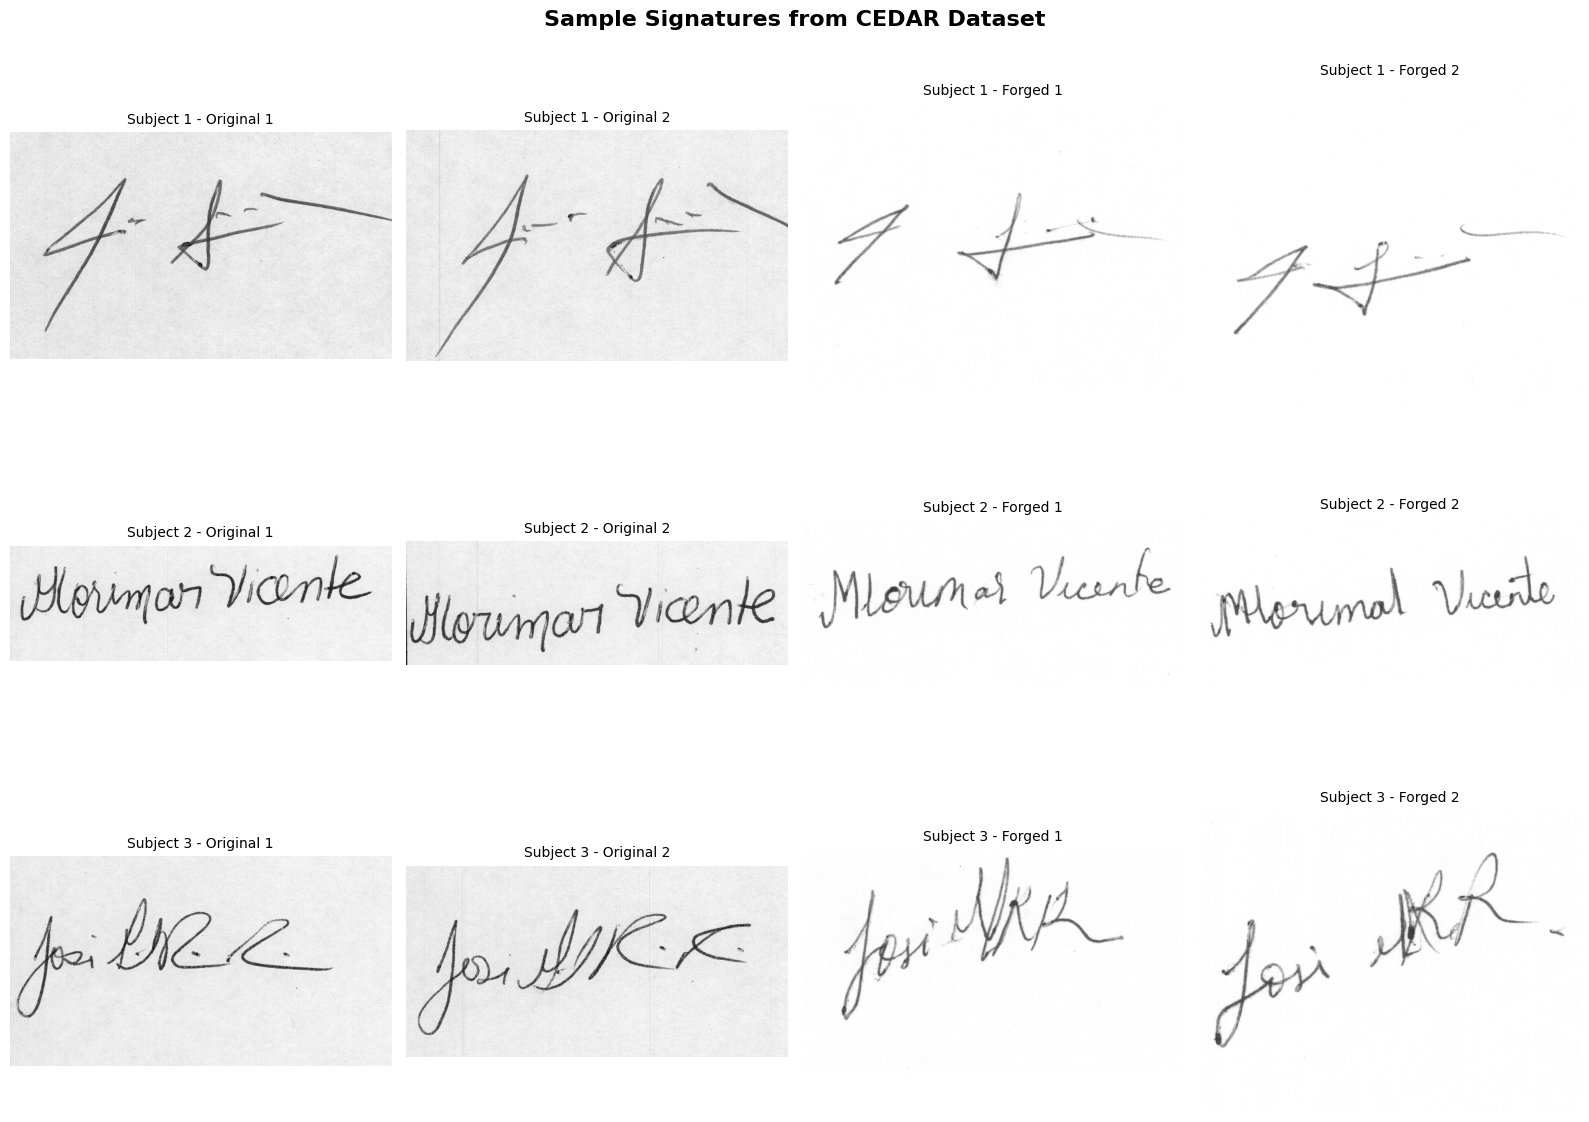

2025-08-04 14:20:36,401 - training - INFO - Analyzing image properties from 100 samples...
2025-08-04 14:20:36,401 - training - INFO - Analyzing image properties from 100 samples...
2025-08-04 14:20:36,401 - training - INFO - Analyzing image properties from 100 samples...
INFO:training:Analyzing image properties from 100 samples...
2025-08-04 14:20:36,422 - training - INFO - EDA report generation complete!
2025-08-04 14:20:36,422 - training - INFO - EDA report generation complete!
2025-08-04 14:20:36,422 - training - INFO - EDA report generation complete!
INFO:training:EDA report generation complete!



IMAGE PROPERTIES ANALYSIS
----------------------------------------
Widths:
  Range: 276.0 - 672.0
  Mean ± Std: 548.0 ± 97.4
  Unique values: 48

Heights:
  Range: 211.0 - 624.0
  Mean ± Std: 355.1 ± 81.3
  Unique values: 66

File_sizes:
  Range: 17.6 - 215.2
  Mean ± Std: 91.9 ± 40.0
  Unique values: 100

Channels:
  Range: 1.0 - 4.0
  Mean ± Std: 1.1 ± 0.7
  Unique values: 2



In [13]:
# Print a complete EDA report

signatures_path = Path("data/raw/cedardataset/signatures")
output_dir = Path("reports/eda")

generate_eda_report(signatures_path, metadata, output_dir)

In [14]:
# I you want to run the EDA report step by step

print_dataset_statistics(metadata)

2025-08-04 14:20:36,435 - training - INFO - Generating dataset statistics...
2025-08-04 14:20:36,435 - training - INFO - Generating dataset statistics...
2025-08-04 14:20:36,435 - training - INFO - Generating dataset statistics...
INFO:training:Generating dataset statistics...


CEDAR DATASET STATISTICS
Total Images: 2640
Original Signatures: 1320
Forged Signatures: 1320
Balance Ratio: 1.00

SUBJECT ANALYSIS
------------------------------
Original signatures:
  Unique subjects: 55
  Subject range: 1 - 55
  Samples per subject: 24 - 24 (avg: 24.0)

Forgeries signatures:
  Unique subjects: 55
  Subject range: 1 - 55
  Samples per subject: 24 - 24 (avg: 24.0)



In [ ]:
# I you want to run the EDA report step by step

plot_dataset_distribution(metadata)

## Create Data Loaders

In [16]:
# If you haven't run it before

dataset_metadata_path = Path("metadata/metadata.json")

metadata = load_metadata(dataset_metadata_path)

2025-08-04 14:21:02,532 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-08-04 14:21:02,532 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-08-04 14:21:02,532 - training - INFO - Metadata loaded from: metadata/metadata.json
INFO:training:Metadata loaded from: metadata/metadata.json


In [17]:
# Update metadata with balanced splits

metadata_with_splits = create_balanced_splits(metadata)

print("\n")
print("You can see the split key updated")
for i, (key, value) in enumerate(metadata_with_splits.items()):
    print(f"{key}: {value}")
    if i == 5:
      break

2025-08-04 14:21:02,544 - training - INFO - Creating balanced splits for signature verification...
2025-08-04 14:21:02,544 - training - INFO - Creating balanced splits for signature verification...
2025-08-04 14:21:02,544 - training - INFO - Creating balanced splits for signature verification...
INFO:training:Creating balanced splits for signature verification...
2025-08-04 14:21:02,547 - training - INFO - Found 1320 original and 1320 forged signatures
2025-08-04 14:21:02,547 - training - INFO - Found 1320 original and 1320 forged signatures
2025-08-04 14:21:02,547 - training - INFO - Found 1320 original and 1320 forged signatures
INFO:training:Found 1320 original and 1320 forged signatures
2025-08-04 14:21:02,555 - training - INFO - Split distribution:
2025-08-04 14:21:02,555 - training - INFO - Split distribution:
2025-08-04 14:21:02,555 - training - INFO - Split distribution:
INFO:training:Split distribution:
2025-08-04 14:21:02,560 - training - INFO -   train: 1846 images (original



You can see the split key updated
original_43_16.png: {'type': 'original', 'subject_id': 43, 'sample_id': 16, 'split': 'train'}
original_10_9.png: {'type': 'original', 'subject_id': 10, 'sample_id': 9, 'split': 'test'}
original_18_12.png: {'type': 'original', 'subject_id': 18, 'sample_id': 12, 'split': 'train'}
original_3_10.png: {'type': 'original', 'subject_id': 3, 'sample_id': 10, 'split': 'val'}
original_9_11.png: {'type': 'original', 'subject_id': 9, 'sample_id': 11, 'split': 'val'}
original_50_19.png: {'type': 'original', 'subject_id': 50, 'sample_id': 19, 'split': 'train'}


In [18]:
# Create dataloaders for training, validation, and test sets

data_path = Path("data/raw/cedardataset/signatures")

dataloaders = create_dataloaders(data_path, metadata_with_splits)

2025-08-04 14:21:02,580 - training - INFO - Creating dataloaders...
2025-08-04 14:21:02,580 - training - INFO - Creating dataloaders...
2025-08-04 14:21:02,580 - training - INFO - Creating dataloaders...
INFO:training:Creating dataloaders...
2025-08-04 14:21:02,587 - training - INFO - Dataset initialized: 1846 images (split: train)
2025-08-04 14:21:02,587 - training - INFO - Dataset initialized: 1846 images (split: train)
2025-08-04 14:21:02,587 - training - INFO - Dataset initialized: 1846 images (split: train)
INFO:training:Dataset initialized: 1846 images (split: train)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/fre

In [19]:
# You can check the dataloaders for each split

for split, loader in dataloaders.items():
    print(f"{split} DataLoader:")
    for i, (images, labels) in enumerate(loader):
        print(f"  Batch {i+1}: {len(images)} images")
        print(f"  Labels: {labels}")
        print(f"  Images shape: {images.shape}")
        if i == 2:
            break
    print("\n")
    print(f"Class counts: {loader.dataset.get_class_counts()}")
    print(f"Subject info: {loader.dataset.get_subject_info()}")

train DataLoader:
  Batch 1: 32 images
  Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1])
  Images shape: torch.Size([32, 3, 224, 224])
  Batch 2: 32 images
  Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1])
  Images shape: torch.Size([32, 3, 224, 224])
  Batch 3: 32 images
  Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0])
  Images shape: torch.Size([32, 3, 224, 224])


Class counts: {'original': 923, 'forgeries': 923}
Subject info: {'unique_subjects': 55, 'subject_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]}
val DataLoader:
  Batch 1: 32 images
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Model Definition & Setup Training

In [21]:
# Model configuration --> Baseline model

BASELINE = True

if BASELINE:
  model_config = {
      'type': 'baseline',
      'num_classes': 2,
      'input_channels': 3
  }
else:
  model_config = {
  'type': 'transfer',
  'model_name': 'resnet50',
  'num_classes': NUM_CLASSES,
  'pretrained': True,
  'use_custom_classifier': True
}

In [ ]:
# Give a look at every avialable model

get_available_models()

In [23]:
# Validate configuration

validate_model_config(model_config)

In [24]:
# Create model

model = create_model(model_config)

In [25]:
# Optimizer e Loss

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

criterion = torch.nn.CrossEntropyLoss()

In [26]:
# Setup experiment

logger = get_logger()

experiment = Experiment(
    name="signature_detection_baseline_v2",
    root="/content/drive/MyDrive/XAI_ProfAI/experiments",
    logger=logger
)
experiment.init()

2025-08-04 14:23:11,533 - training - INFO - Creating new experiment
2025-08-04 14:23:11,533 - training - INFO - Creating new experiment
2025-08-04 14:23:11,533 - training - INFO - Creating new experiment
2025-08-04 14:23:11,533 - training - INFO - Creating new experiment
INFO:training:Creating new experiment


In [27]:
# Setup callbacks

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['training']['early_stopping']['patience'],
        min_delta=config['training']['early_stopping']['min_delta'],
        verbose=True
    ),
    ModelCheckpoint(
        filepath='best_baseline_model.pth',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        patience=5,
        factor=0.1,
        verbose=True
    )
]

In [28]:
# Initialize trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

trainer = ModelTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    experiment=experiment,
    device=device,
    logger=logger
)

Using device: cuda


In [29]:
# Train the model

trained_model = trainer.train(
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    num_epochs=NUM_EPOCHS,
    callbacks=callbacks
)

torch.save(trained_model.state_dict(), experiment.root / 'final_model_baseline_v2.pth')

2025-08-04 14:23:28,698 - training - INFO - Start training for 50 epoche
2025-08-04 14:23:28,698 - training - INFO - Start training for 50 epoche
2025-08-04 14:23:28,698 - training - INFO - Start training for 50 epoche
2025-08-04 14:23:28,698 - training - INFO - Start training for 50 epoche
INFO:training:Start training for 50 epoche
2025-08-04 14:23:28,701 - training - INFO - Model: BaselineCNN
2025-08-04 14:23:28,701 - training - INFO - Model: BaselineCNN
2025-08-04 14:23:28,701 - training - INFO - Model: BaselineCNN
2025-08-04 14:23:28,701 - training - INFO - Model: BaselineCNN
INFO:training:Model: BaselineCNN
2025-08-04 14:23:28,706 - training - INFO - Optimizer: Adam
2025-08-04 14:23:28,706 - training - INFO - Optimizer: Adam
2025-08-04 14:23:28,706 - training - INFO - Optimizer: Adam
2025-08-04 14:23:28,706 - training - INFO - Optimizer: Adam
INFO:training:Optimizer: Adam
2025-08-04 14:23:28,709 - training - INFO - Criterion: CrossEntropyLoss
2025-08-04 14:23:28,709 - training - I


Epoch 00001: val_loss improved from inf to 0.69301, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:24:00,246 - training - INFO - Epoca 2 - accuracy: 0.5027 | precision: 0.5021


Epoch 00003: val_loss improved from 0.69301 to 0.69225, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:24:32,095 - training - INFO - Epoca 4 - accuracy: 0.5186 | precision: 0.5197


Epoch 00004: val_loss improved from 0.69225 to 0.69088, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:24:48,337 - training - INFO - Epoca 5 - accuracy: 0.5351 | precision: 0.5362


Epoch 00005: val_loss improved from 0.69088 to 0.68178, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:25:04,454 - training - INFO - Epoca 6 - accuracy: 0.5987 | precision: 0.5988


Epoch 00007: val_loss improved from 0.68178 to 0.57883, saving model to best_baseline_model.pth


2025-08-04 14:25:23,111 - training - INFO - Epoch 8/50
2025-08-04 14:25:23,111 - training - INFO - Epoch 8/50
2025-08-04 14:25:23,111 - training - INFO - Epoch 8/50
INFO:training:Epoch 8/50
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or eve


Epoch 00011: val_loss improved from 0.57883 to 0.56764, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:26:41,311 - training - INFO - Epoca 12 - accuracy: 0.6848 | precision: 0.685


Epoch 00013: val_loss improved from 0.56764 to 0.54400, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:27:14,055 - training - INFO - Epoca 14 - accuracy: 0.7023 | precision: 0.702


Epoch 00015: val_loss improved from 0.54400 to 0.51601, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:27:46,909 - training - INFO - Epoca 16 - accuracy: 0.6831 | precision: 0.683


Epoch 00017: val_loss improved from 0.51601 to 0.51287, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:28:19,141 - training - INFO - Epoca 18 - accuracy: 0.7050 | precision: 0.705


Epoch 00019: val_loss improved from 0.51287 to 0.46391, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:28:51,490 - training - INFO - Epoca 20 - accuracy: 0.7588 | precision: 0.758


Epoch 00021: val_loss improved from 0.46391 to 0.43128, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:29:24,787 - training - INFO - Epoca 22 - accuracy: 0.7462 | precision: 0.746


Epoch 00023: val_loss improved from 0.43128 to 0.42345, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:29:56,892 - training - INFO - Epoca 24 - accuracy: 0.7747 | precision: 0.775


Epoch 00024: val_loss improved from 0.42345 to 0.37060, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:30:13,071 - training - INFO - Epoca 25 - accuracy: 0.7873 | precision: 0.787


Epoch 00027: val_loss improved from 0.37060 to 0.33594, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:31:02,303 - training - INFO - Epoca 28 - accuracy: 0.8081 | precision: 0.808


Epoch 00030: val_loss improved from 0.33594 to 0.28112, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:31:51,548 - training - INFO - Epoca 31 - accuracy: 0.8185 | precision: 0.818


Epoch 00033: val_loss improved from 0.28112 to 0.26716, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:32:41,160 - training - INFO - Epoca 34 - accuracy: 0.8328 | precision: 0.833

Epoch 38: reducing learning rate of group 0 to 1.0000e-04.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:34:04,085 - training - INFO - Epoca 39 - accuracy: 0.8525 | precision: 0.853

Epoch 43: early stopping


## Validation on Test Set

In [30]:
# Evaluation on test set

test_logs = trainer.validate(dataloaders['test'])
experiment.save_history('test', **test_logs)
logger.info(f"Test Results: {test_logs}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:36:17,263 - training - INFO - Test Results: {'accuracy': np.float64(0.8467336683417085), 'precision': 0.8637158296249204, 'recall': 0.8467336683417085, 'f1': 0.8449235093098273, 'loss': 0.3385254438198991}
2025-08-04 14:36:17,263 - training - INFO - Test Results: {'accuracy': np.float64(0.8467336683417085), 'precision': 0.8637158296249204, 'recall': 0.8467336683417085, 'f1': 0.8449235093098273, 'loss': 0.3385254438198991}
2025-08-04 14:36:17,263 - training - INFO - Test Results: {'accuracy': np.float64(0.8467336683417085), 'p

In [31]:
# Get predictions on test set

test_targets, test_predictions = trainer.predict(dataloaders['test'])

plot_confusion_matrix(test_targets, test_predictions, classes = ["original", "forgery"],)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-08-04 14:36:21,132 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-08-04 14:36:21,132 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-08-04 14:36:21,132 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-08-04 14:36:21,132 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
INFO:training:Confusion matrix saved as 'confusion_matrix.png'


In [32]:
# Save test results
test_results = {
    'targets': test_targets.tolist(),
    'predictions': test_predictions.tolist()
}

with open(f"{experiment.results_dir}/test_results.json", 'w') as f:
    json.dump(test_results, f)

## Analysis of Results

In [ ]:
# Generate and Save plots training history

experiment.plot_history()

In [33]:
# Evaluation train and validation results

scatter_plot_metrics(f'{experiment.root}/history/train.csv',
                     f'{experiment.root}/history/val.csv')

In [34]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv(f"{experiment.root}/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv(f"{experiment.root}/history/val.csv", index=False)

test = pd.read_csv(f"{experiment.root}/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv(f"{experiment.root}/history/test.csv", index=False)

In [35]:
# Calculate average metrics for last n epochs

experiment = Experiment("signature_detection_baseline_v2", "/content/drive/MyDrive/XAI_ProfAI/experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")

avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

Average validation metrics: {'loss': 0.32711350202861456, 'accuracy': 0.8398989898989899, 'precision': 0.8646853812382206, 'recall': 0.8398989898989899, 'f1': 0.8369912554699142, 'lr': 0.0}


In [36]:
# Export results in JSON

experiment.export_results_to_json("/content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v2/results/results.json")

2025-08-04 14:37:10,121 - signature_detection_baseline_v2 - INFO - Successfully exported results to /content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v2/results/results.json
INFO:signature_detection_baseline_v2:Successfully exported results to /content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v2/results/results.json


In [37]:
# Find best epoch according to validation accuracy

metric = 'accuracy'

best_epoch = experiment.get_best_epoch(metric, mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch} with {100*experiment.history['val'][metric][best_epoch-1]:.1f}%")

Best validation accuracy was achieved at epoch 33 with 91.4%


In [38]:
# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



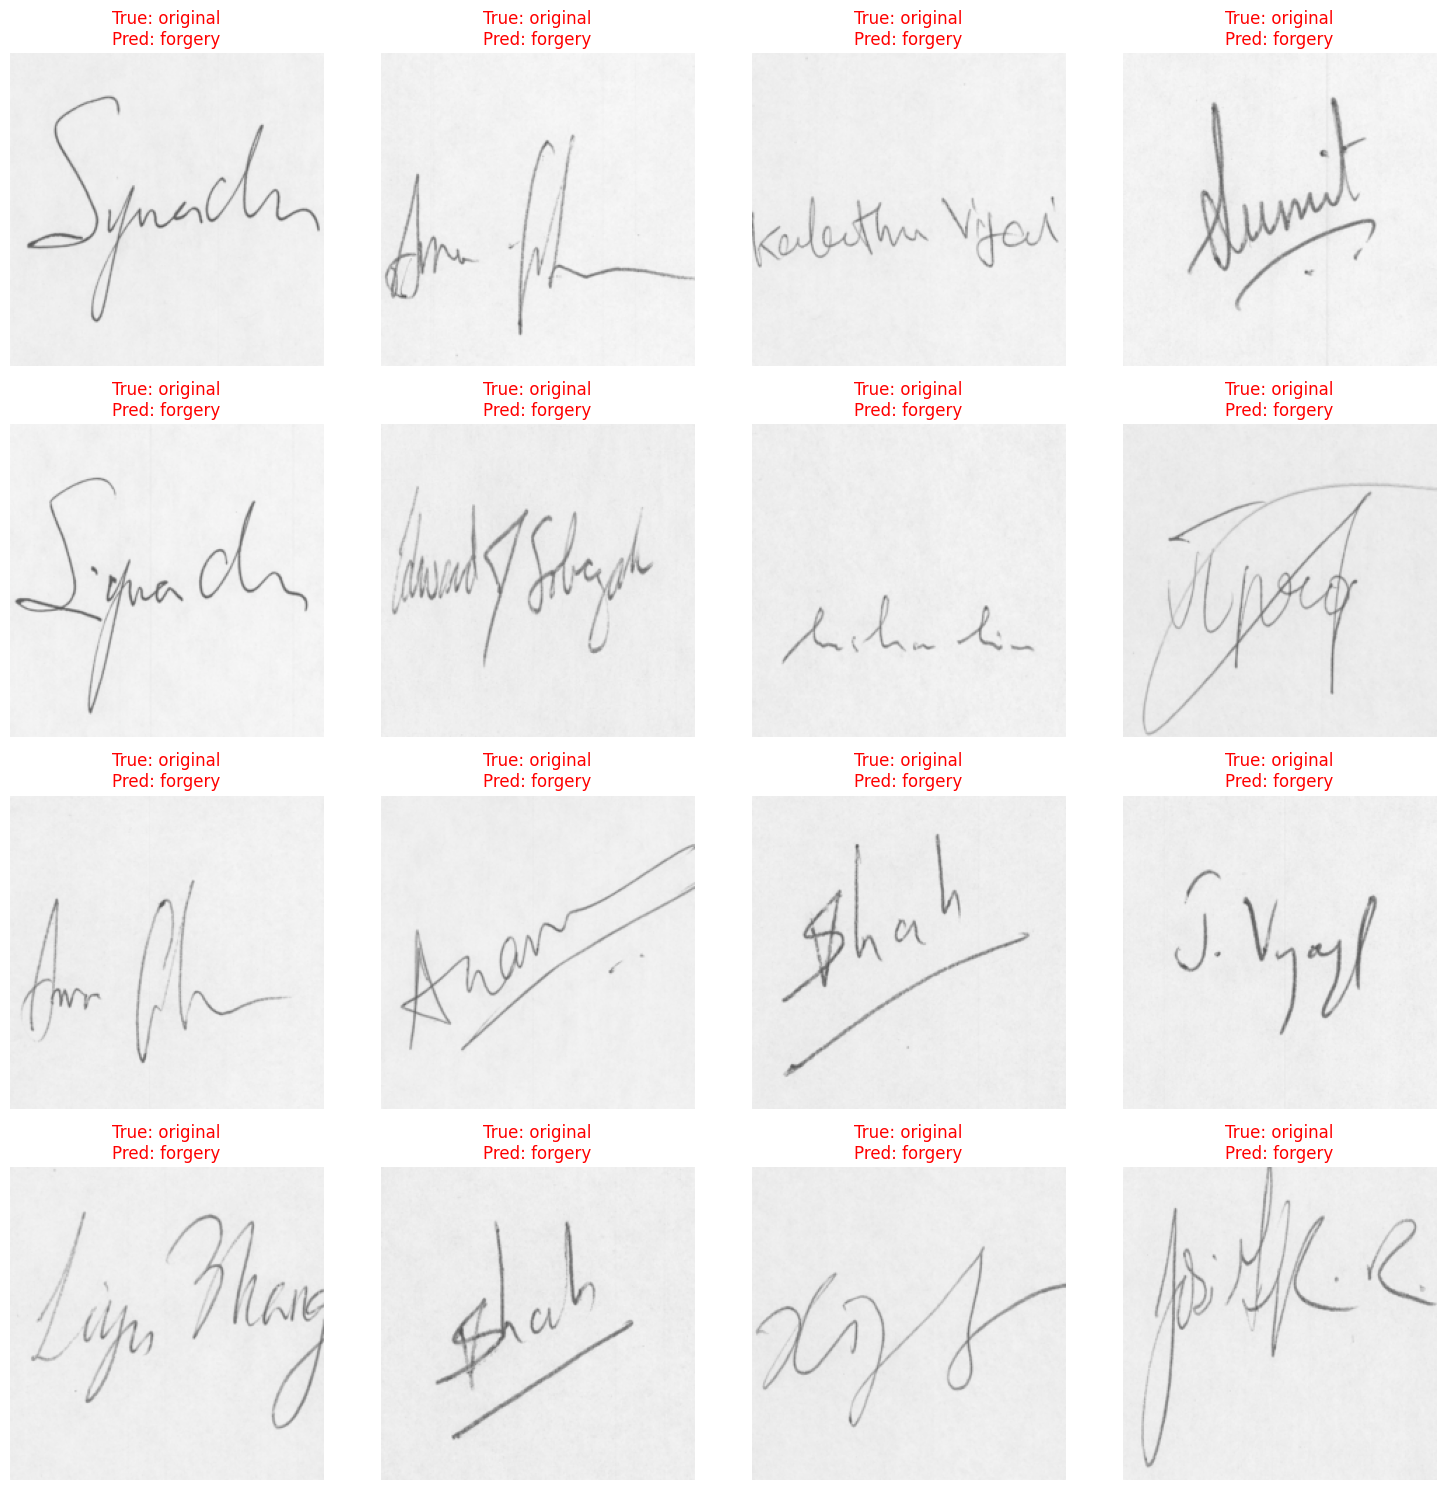

In [39]:
# Plot misclassified images with ground truth and prediction

plot_misclassified_images(
    model=trained_model,
    dataloader=dataloaders['test'],
    device=device,
    num_images=16,
    class_names=["original", "forgery"],
    mean=config['preprocessing']['image']['mean'],
    std=config['preprocessing']['image']['std']
)

## eXplainability

In [40]:
from src.xai.explainer import SignatureExplainer
from src.xai.visualizer import XAIVisualizer
from src.visualization.complete_xai_viz import TestImageSelector

In [68]:
# load trained model

BASELINE = False

if BASELINE:
  model_config = {
      'type': 'baseline',
      'num_classes': 2,
      'input_channels': 3
  }
else:
  model_config = {
  'type': 'transfer',
  'model_name': 'resnet50',
  'num_classes': NUM_CLASSES,
  'pretrained': True,
  'use_custom_classifier': True
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model(model_config)
model.load_state_dict(torch.load("/content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_resnet_v1/final_model_resnet_v1.pth"))
model.to(device)
model.eval()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

TransferLearningModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256

In [71]:
selector = TestImageSelector(data_path, metadata, model, device)

In [72]:
selector.list_available_subjects()

AVAILABLE SUBJECTS IN TEST SET:
----------------------------------------
Subject  1: 2 original, 4 forged
Subject  2: 0 original, 3 forged
Subject  3: 3 original, 5 forged
Subject  4: 5 original, 2 forged
Subject  5: 4 original, 1 forged
Subject  6: 3 original, 5 forged
Subject  7: 0 original, 5 forged
Subject  8: 3 original, 3 forged
Subject  9: 2 original, 6 forged
Subject 10: 4 original, 2 forged
Subject 11: 2 original, 2 forged
Subject 12: 1 original, 5 forged
Subject 13: 4 original, 2 forged
Subject 14: 7 original, 5 forged
Subject 15: 5 original, 4 forged
Subject 16: 1 original, 2 forged
Subject 17: 9 original, 2 forged
Subject 18: 6 original, 4 forged
Subject 19: 3 original, 2 forged
Subject 20: 6 original, 5 forged
Subject 21: 5 original, 5 forged
Subject 22: 3 original, 4 forged
Subject 23: 5 original, 4 forged
Subject 24: 3 original, 6 forged
Subject 25: 7 original, 5 forged
Subject 26: 3 original, 3 forged
Subject 27: 5 original, 3 forged
Subject 28: 3 original, 4 forged
Sub

IMAGE ANALYSIS: forgeries_51_23.png
Subject ID: 51
Sample ID: 23
True Class: Forged (1)
Predicted Class: Forged (1)
Confidence: 1.0000
Prediction: CORRECT :)

COMPARISON WITH ORIGINAL:
Original file: original_51_2.png
Original prediction: Original (conf: 1.0000)



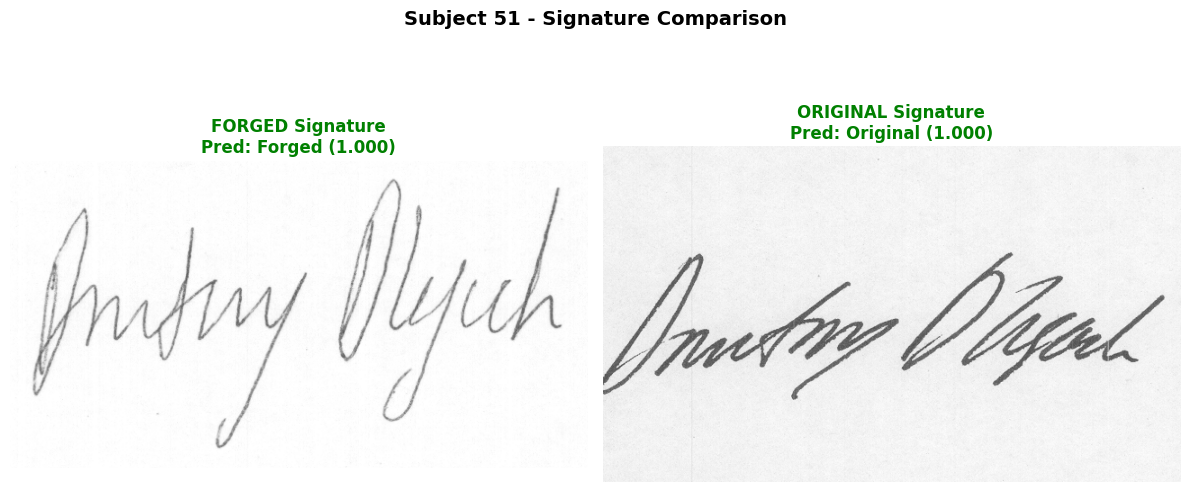

In [73]:
results_random = selector.show_image_analysis(
    selector.get_random_image("forgeries")[0],
    show_comparison=True
)

IMAGE ANALYSIS: forgeries_11_13.png
Subject ID: 11
Sample ID: 13
True Class: Forged (1)
Predicted Class: Forged (1)
Confidence: 1.0000
Prediction: CORRECT :)

COMPARISON WITH ORIGINAL:
Original file: original_11_16.png
Original prediction: Original (conf: 1.0000)



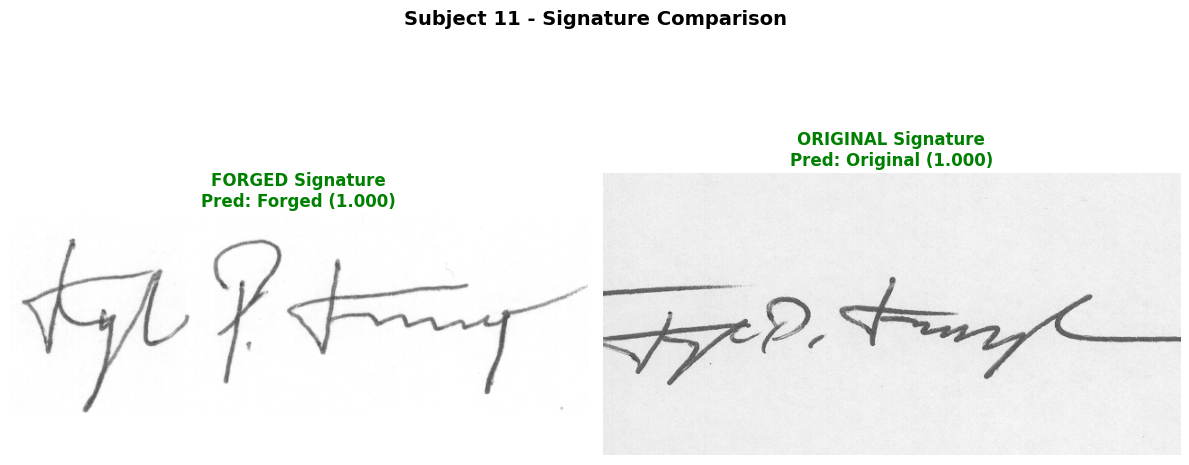

In [74]:
# Analysis per subject

filename, info = selector.get_image_by_subject(subject_id=11, signature_type="forgeries")
results_id = selector.show_image_analysis(filename)

In [98]:
# Access last conv layer in layer4
last_bottleneck = model.base_model.layer4[-1]
last_conv = last_bottleneck.conv3
print(last_conv)
for name, module in model.named_modules():
    if module is last_conv:
        print(f"Last conv layer name: {name}")
        break

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
Last conv layer name: base_model.layer4.2.conv3


2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,784 - training - INFO - SignatureExplainer initialized with model: TransferLearningModel
INFO:training:SignatureExplainer initialized with model: TransferLearningModel
2025-08-04 15:00:29,790 - training - INFO - Generating all explanation methods...
2025-08-04 15:00:29,790 - training - INFO - Generating all explanation methods...
2025-08-04 15:00:29,790 - training - INFO - Generating all explanation methods...
2025-08-04 15:00:29,7

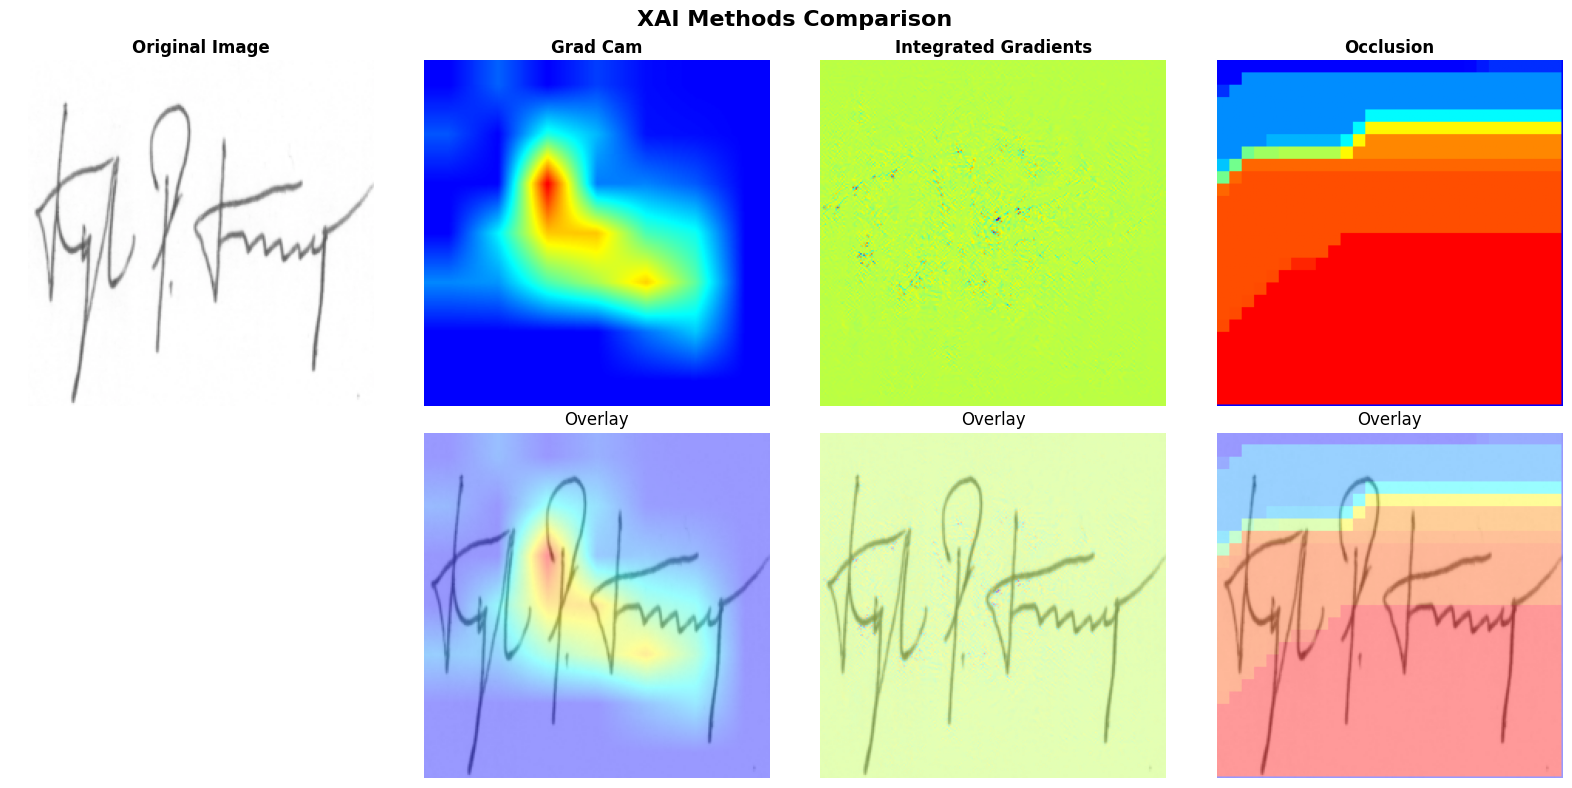

In [97]:
explainer = SignatureExplainer(model, device)
explanations = explainer.compare_explanations(results_id["tensor"].unsqueeze(0), target_class=1, target_layer="base_model.layer4.2.conv3")
visualizer.plot_comparison(results_id["tensor"], explanations)